In [1]:
# Importation des modules necessaires
import sys
sys.path.insert(0,'../')
import argopy
import xarray as xr
import glob
import numpy as np
from m_argo_data import *
from m_WOA_data import *
from m_NCEP_data import *

from m_fonctions import *
import warnings
warnings.filterwarnings("ignore",category=RuntimeWarning)
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seawater as sw

/var/folders/vb/_nx050wx16vc32wc3vf7tkrw000h29/T/ipykernel_27956/2067290737.py:17: UserWarning: The seawater library is deprecated! Please use gsw instead.
  import seawater as sw


In [2]:
#
# Init.
#
num_float = '7902215'

# Infos pour correction WOA
rep_data_argo = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/bitete_doxy_aanderaa/'
fic_WOA = '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/WOA/WOA2018_DECAV_monthly_5500_1deg.nc'
which_var = 1
min_pres_interp = 0
max_pres_interp = 100

pres_qc = [1,2,8]
temp_qc = [1,2,8]
sal_qc = [1,2,8]
doxy_qc = [1,2,3,8]

# Infos pour correction NCEP
rep_NCEP_data= '/Users/chemon/ARGO_NEW/LOCODOX/DATA/LOCODOX_EXTERNAL_DATA/NCEP/'
ftp_server = 'ftp.cdc.noaa.gov'
rep_ftp = 'Datasets/ncep.reanalysis/surface'
rep_local = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/NCEP_DATA/'
ncep_variables = ['slp','air.sig995','rhum.sig995']
code_inair = [699,711,799]
code_inwater = [690,710]
min_pres = 0
max_pres = 10

In [3]:
launch_date = read_argo_launch_date(num_float,rep_data_argo)
dsargo = read_argo_data_for_WOA(num_float,rep_data_argo,which_var,temp_qc,sal_qc,doxy_qc)
#print(launch_date)
#dsargo

In [4]:
delta_T_WOA = (dsargo['JULD'].values - launch_date)
delta_T_WOA = delta_T_WOA.astype(float)
delta_T_WOA = delta_T_WOA/1e9/86400 # Difference en jour

In [5]:
dswoa = read_WOA(fic_WOA,dsargo['LONGITUDE'],dsargo['LATITUDE'],dsargo['JULD'])
#dswoa

Extrapolation WOA temporelle en cours pour la variable : doxywoa
Extrapolation WOA temporelle en cours pour la variable : Psatwoa
Extrapolation WOA temporelle en cours pour la variable : density
Extrapolation WOA temporelle en cours pour la variable : preswoa
Extrapolation WOA temporelle en cours pour la variable : PSAL_WOA
Extrapolation WOA temporelle en cours pour la variable : TEMP_WOA


In [6]:
# Interpolation WOA et ARGO ur une grille reguliere en pression.
var_to_interpol = [var for var in dswoa.data_vars if "Depth" in dswoa[var].dims]
nb_profil = len(dswoa['N_PROF'])
woa_interp = interp_pres_grid(min_pres_interp,max_pres_interp,nb_profil,var_to_interpol,dswoa,'preswoa')

var_to_interpol = [var for var in dsargo.data_vars if "N_LEVELS" in dsargo[var].dims]
nb_profil = len(dsargo['N_PROF'])
argo_interp = interp_pres_grid(min_pres_interp,max_pres_interp,nb_profil,var_to_interpol,dsargo,'PRES_ARGO')

Interpolation de la variable doxywoa sur grille reguliere en pression
Interpolation de la variable Psatwoa sur grille reguliere en pression
Interpolation de la variable density sur grille reguliere en pression
Interpolation de la variable preswoa sur grille reguliere en pression
Interpolation de la variable PSAL_WOA sur grille reguliere en pression
Interpolation de la variable TEMP_WOA sur grille reguliere en pression
Interpolation de la variable TEMP_ARGO sur grille reguliere en pression
Interpolation de la variable TEMP_ARGO_QC sur grille reguliere en pression
Interpolation de la variable PSAL_ARGO sur grille reguliere en pression
Interpolation de la variable PSAL_ARGO_QC sur grille reguliere en pression
Interpolation de la variable DOXY_ARGO sur grille reguliere en pression
Interpolation de la variable DOXY_ARGO_QC sur grille reguliere en pression
Interpolation de la variable PRES_ARGO sur grille reguliere en pression
Interpolation de la variable PRES_ARGO_QC sur grille reguliere en

In [7]:
# Calcul de PPOX WOA.
ppox_WOA = O2stoO2p(woa_interp['Psatwoa'],argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO']) 
ppox_WOA_mean = np.nanmean(ppox_WOA,axis=1)

In [8]:
ana_dens = sw.pden(argo_interp['PSAL_ARGO'],argo_interp['TEMP_ARGO'],np.arange(min_pres_interp,max_pres_interp+1,1),0)
O2_ARGO_umolL = umolkg_to_umolL(argo_interp['DOXY_ARGO'],dsargo['DOXY_ARGO'].units,ana_dens)

In [9]:
ppox_ARGO = O2ctoO2p(O2_ARGO_umolL,argo_interp['TEMP_ARGO'],argo_interp['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_ARGO_mean = np.nanmean(ppox_ARGO,axis=1)

In [10]:
# Ajustement de G via WOA
initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean, ppox_WOA_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)

initial_guess = 1  # Valeurs initiales pour G 
params_Gain_WOA, covariance = curve_fit(model_Gain, ppox_ARGO_mean/ppox_ARGO_mean, ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit')
print(params_Gain_WOA)
#params_Gain, covariance = curve_fit(model_Gain, PPOX1, NCEP_PPOX, p0=initial_guess,nan_policy='omit',method='dogbox')
#print(params_Gain)


[1.11761534]
[1.12085756]


In [11]:
# Ajustement des paramètres G et D via WOA
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_WOA, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [ppox_ARGO_mean/ppox_ARGO_mean,delta_T_WOA], ppox_WOA_mean/ppox_ARGO_mean, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_WOA)

[ 1.09228649 17.61399516]
[ 1.09554153 16.64030766]


Recherche de la valeur de PSAL dans Sprof correcte la plus proche de la surface entre 0 et 10
Recherche de la valeur de PSAL_ADJUSTED dans Sprof correcte la plus proche de la surface entre 0 et 10


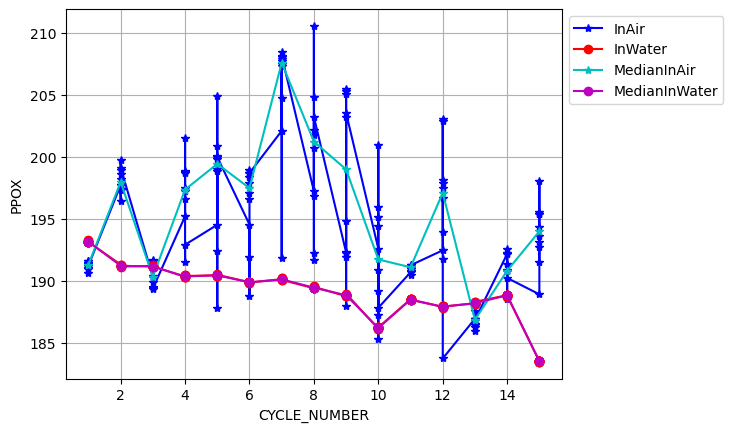

On conserve les donnees PSAL


In [12]:
# Correction via NCEP
dsair,dsinwater,optode_height = read_argo_data_for_NCEP(num_float,rep_data_argo,which_var,code_inair,code_inwater,min_pres,max_pres)

In [ ]:
#download_NCEP(dsair['JULD'],ftp_server,rep_ftp,rep_local,ncep_variables)
#annee = [int(dsair['JULD'][0].dt.year),int(dsair['JULD'][-1].dt.year)]
annee = [2023,2024]
download_NCEP_force(annee,ftp_server,rep_ftp,rep_local,ncep_variables)

ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum = read_NCEP(rep_NCEP_data,dsair['LONGITUDE_ARGO'],dsair['LATITUDE_ARGO'],dsair['JULD'])

z0q = 1e-4
NCEP_PPOX = calcul_NCEP_PPOX(dsinwater,ds_NCEP_air,ds_NCEP_slp,ds_NCEP_rhum,optode_height,z0q)

delta_T_NCEP = (dsair['JULD'].values - launch_date)
delta_T_NCEP = delta_T_NCEP.astype(float)
delta_T_NCEP = delta_T_NCEP/1e9/86400 # Difference en jour

PPOX1 = dsair['PPOX_DOXY'].values
PPOX2 = dsinwater['PPOX_DOXY'].values
initial_guess = 1
params_Gain_NCEP, covariance = curve_fit(model_Gain, PPOX1/PPOX1, NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit')

initial_guess = [1, 0]  # Valeurs initiales pour G et C
params_Gain_NCEP_CarryOver, covariance = curve_fit(model_Gain_CarryOver, [PPOX1,PPOX2], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [188]:
params_Gain_NCEP_CarryOver

array([ 1.09593474, -3.83601055])

In [189]:
initial_guess = [1, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], NCEP_PPOX/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
initial_guess = [1, 0, 0]  # Valeurs initiales pour G et D et C
params_Gain_Derive_NCEP_CarryOver, covariance = curve_fit(model_Gain_Derive_CarryOver, [PPOX1,PPOX2,delta_T_NCEP], NCEP_PPOX, p0=initial_guess,nan_policy='omit')

In [190]:
params_Gain_Derive_NCEP_CarryOver

array([ 1.07733487, -2.91015831,  9.87625694])

In [191]:
initial_guess = [1] 
res = model_Gain_CarryOver([PPOX1,PPOX2],*params_Gain_NCEP_CarryOver)
params_Gain_NCEP_CarryOver_final, covariance = curve_fit(model_Gain, PPOX1, res, p0=initial_guess,nan_policy='omit')
print(params_Gain_NCEP_CarryOver_final)
initial_guess = [1, 0]  
res2 = model_Gain_Derive_CarryOver([PPOX1,PPOX2,delta_T_NCEP],*params_Gain_Derive_NCEP_CarryOver)
params_Gain_Derive_NCEP_CarryOver_final, covariance,info,mesg,ier = curve_fit(model_Gain_Derive, [PPOX1/PPOX1,delta_T_NCEP], res2/PPOX1, p0=initial_guess,nan_policy='omit',full_output=True)
print(params_Gain_Derive_NCEP_CarryOver_final)


[1.06706809]
[1.05298451 9.03696964]


In [192]:
print(params_Gain_WOA)
print(params_Gain_NCEP)
print(params_Gain_NCEP_CarryOver[0])
print(params_Gain_Derive_WOA)
print(params_Gain_Derive_NCEP)
print(params_Gain_Derive_NCEP_CarryOver[0],params_Gain_Derive_NCEP_CarryOver[2])
print(params_Gain_NCEP_CarryOver_final)
print(params_Gain_Derive_NCEP_CarryOver_final)

[1.12085756]
[1.06581017]
1.0959347420548968
[ 1.09554153 16.64030766]
[ 1.04579309 12.09307183]
1.0773348713579989 9.876256940500355
[1.06706809]
[1.05298451 9.03696964]


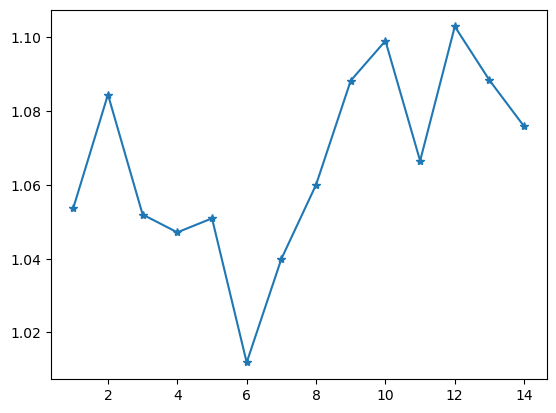

1.065810169618447
1.063301128993491


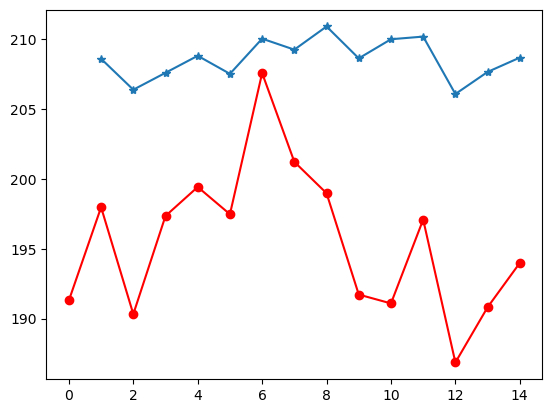

In [202]:
plt.figure()
plt.plot(NCEP_PPOX/PPOX1,'*-')
plt.show()
print(np.nanmean(NCEP_PPOX/PPOX1))
print(np.nanmedian(NCEP_PPOX/PPOX1))
plt.figure()
plt.plot(NCEP_PPOX,'*-')
plt.plot(PPOX1,'o-r')
plt.show()


In [54]:
optode_height

array([-0.3])

In [55]:
print(dsair['CYCLE_NUMBER'].values)
print(dsinwater['CYCLE_NUMBER'].values)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]


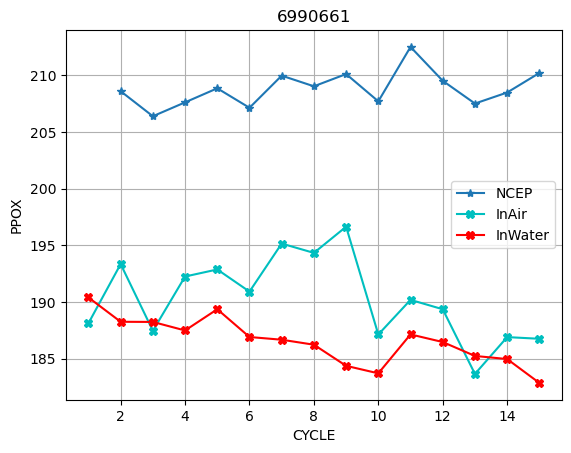

In [56]:
plt.figure()
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'*-')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1,'Xc-')
plt.plot(dsinwater['CYCLE_NUMBER'],PPOX2,'Xr-')
plt.grid()
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.legend(['NCEP','InAir','InWater'])
plt.title(num_float)
plt.savefig('/Users/chemon/ARGO_NEW/rinko_aanderaa/donnees_crossroad/cmp_ppox_ncep_2.png')


In [27]:
dsair['LATITUDE_ARGO'].values

array([41.75922167, 41.84057833, 41.97933167, 42.16527833, 42.45609   ,
       42.66883   , 42.86258   , 43.15310833, 43.48016833, 43.47163333,
       43.92105   , 43.97324167, 44.00371333, 44.18602   , 44.14208   ])

In [17]:
delta_T_NCEP

array([  2.3928125 ,   5.39065972,   8.3875    ,  11.38395833,
        21.16866898,  31.09847222,  40.99024306,  51.12956019,
        61.39166667,  71.17876157,  81.38577546,  91.14185185,
       101.38392361, 111.38238426, 121.38300926])

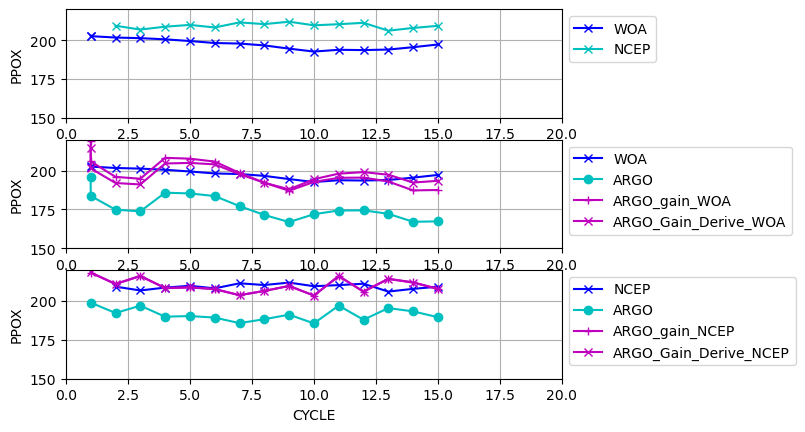

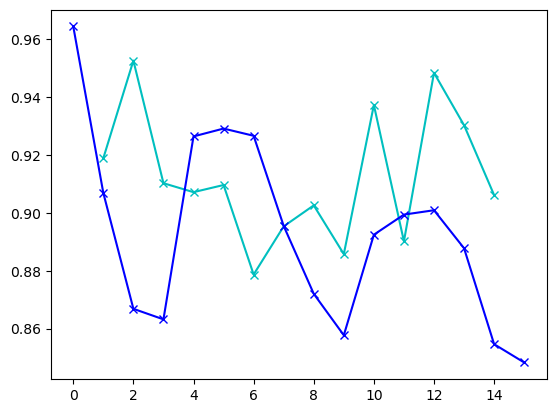

In [18]:
plt.figure()
plt.subplot(3,1,1)
plt.plot(dsargo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-c')
plt.ylim([150,220])
plt.xlim([0,20])
plt.grid()
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.legend(['WOA','NCEP'],loc='upper left',bbox_to_anchor=(1,1))

plt.subplot(3,1,2)
plt.plot(dsargo['CYCLE_NUMBER'],ppox_WOA_mean,'x-b')
plt.plot(dsargo['CYCLE_NUMBER'],ppox_ARGO_mean,'o-c')
plt.plot(dsargo['CYCLE_NUMBER'],model_Gain(ppox_ARGO_mean,*params_Gain_WOA),'+m-')
plt.plot(dsargo['CYCLE_NUMBER'],model_Gain_Derive([ppox_ARGO_mean,delta_T_WOA],*params_Gain_Derive_WOA),'xm-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([150,220])
plt.xlim([0,20])
plt.legend(['WOA','ARGO','ARGO_gain_WOA','ARGO_Gain_Derive_WOA'],loc='upper left',bbox_to_anchor=(1,1))
plt.subplot(3,1,3)
plt.plot(dsair['CYCLE_NUMBER'],NCEP_PPOX,'x-b')
plt.plot(dsair['CYCLE_NUMBER'],PPOX1,'o-c')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain(PPOX1,*params_Gain_NCEP),'+m-')
plt.plot(dsair['CYCLE_NUMBER'],model_Gain_Derive([PPOX1,delta_T_NCEP],*params_Gain_Derive_NCEP),'xm-')
plt.xlabel('CYCLE')
plt.ylabel('PPOX')
plt.grid()
plt.ylim([150,220])
plt.xlim([0,20])
plt.legend(['NCEP','ARGO','ARGO_gain_NCEP','ARGO_Gain_Derive_NCEP'],loc='upper left',bbox_to_anchor=(1,1))

plt.figure()
plt.plot(PPOX1/NCEP_PPOX,'-xc')
plt.plot(ppox_ARGO_mean/ppox_WOA_mean,'xb-')



In [18]:
#new_pres = np.arange(min_pres_interp,max_pres_interp+1,1).reshape(1,max_pres_interp+1-min_pres_interp)
#print(new_pres.shape)
#new_pres = np.tile(new_pres.transpose(),psat_argo.shape[0]).transpose()
delta_T = delta_T_WOA
nb_depth = len(dsargo['N_LEVELS'])
delta_T = delta_T.reshape(nb_profil,1)
delta_T = np.tile(delta_T,nb_depth)

ana_dens = sw.pden(dsargo['PSAL_ARGO'],dsargo['TEMP_ARGO'],dsargo['PRES_ARGO'],0)
O2_ARGO_umolL = umolkg_to_umolL(dsargo['DOXY_ARGO'],dsargo['DOXY_ARGO'].units,ana_dens)
ppox_a_corriger = O2ctoO2p(O2_ARGO_umolL,dsargo['TEMP_ARGO'],dsargo['PSAL_ARGO']) # On calcule PPOX pour P=0
ppox_corr_NCEP = model_Gain(ppox_a_corriger,*params_Gain_NCEP)
ppox_corr_WOA = model_Gain(ppox_a_corriger,*params_Gain_WOA)

O2_ARGO_corr_NCEP = O2ptoO2c(ppox_corr_NCEP,dsargo['TEMP_ARGO'],dsargo['PSAL_ARGO'])/ana_dens*1000
O2_ARGO_corr_WOA = O2ptoO2c(ppox_corr_WOA,dsargo['TEMP_ARGO'],dsargo['PSAL_ARGO'])/ana_dens*1000

ppox_corr2_NCEP = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_NCEP)
ppox_corr2_WOA = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_WOA)

O2_ARGO_corr2_NCEP = O2ptoO2c(ppox_corr2_NCEP,dsargo['TEMP_ARGO'],dsargo['PSAL_ARGO'])/ana_dens*1000
O2_ARGO_corr2_WOA = O2ptoO2c(ppox_corr2_WOA,dsargo['TEMP_ARGO'],dsargo['PSAL_ARGO'])/ana_dens*1000

In [19]:
dsctd = xr.open_dataset("/Volumes/lpo5/HYDROCEAN/OVIDE18_TEMP/CLC/ov18d081_clc.nc",engine='netcdf4')

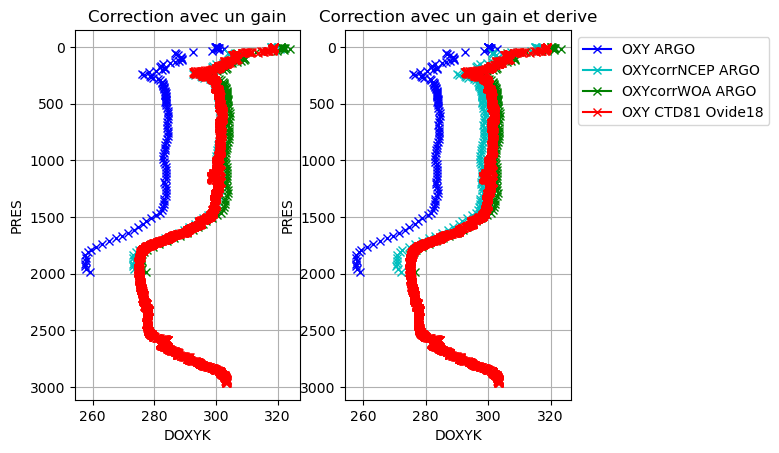

In [20]:
plt.figure()
plt.subplot(1,2,1)
_ = plt.plot(dsargo['DOXY_ARGO'][1,:],dsargo['PRES_ARGO'][1,:],'-xb')
plt.gca().invert_yaxis()
_ = plt.plot(O2_ARGO_corr_NCEP[1,:],dsargo['PRES_ARGO'][1,:],'-xc')
_ = plt.plot(O2_ARGO_corr_WOA[1,:],dsargo['PRES_ARGO'][1,:],'-xg')
plt.grid()
_ = plt.plot(dsctd['OXYK'],dsctd['PRES'],'-xr')
plt.xlabel('DOXYK')
plt.ylabel('PRES')
plt.title('Correction avec un gain')
#_ = plt.legend(['OXY ARGO','OXYcorrNCEP ARGO','OXYcorrWOA ARGO','OXY CTD81 Ovide18'],loc='lower center',bbox_to_anchor=(1,1))

plt.subplot(1,2,2)
_ = plt.plot(dsargo['DOXY_ARGO'][1,:],dsargo['PRES_ARGO'][1,:],'-xb')
plt.gca().invert_yaxis()
_ = plt.plot(O2_ARGO_corr2_NCEP[1,:],dsargo['PRES_ARGO'][1,:],'-xc')
_ = plt.plot(O2_ARGO_corr2_WOA[1,:],dsargo['PRES_ARGO'][1,:],'-xg')
plt.grid()
_ = plt.plot(dsctd['OXYK'],dsctd['PRES'],'-xr')
plt.xlabel('DOXYK')
plt.ylabel('PRES')
plt.title('Correction avec un gain et derive')
_ = plt.legend(['OXY ARGO','OXYcorrNCEP ARGO','OXYcorrWOA ARGO','OXY CTD81 Ovide18'],loc='upper left',bbox_to_anchor=(1,1))

In [21]:
fic_argo = glob.glob(rep_data_argo + num_float + '/profiles/B?' + num_float + '*.nc')
print(fic_argo[150])

/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_075.nc


In [29]:
fic_argo[150].replace('BD','BR',1)

'/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BR6902802_075.nc'

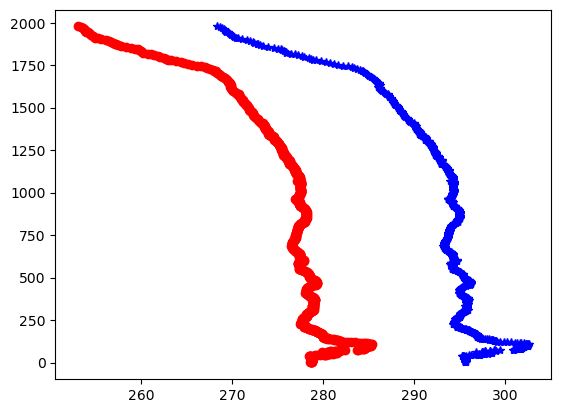

In [22]:
dsargo_oxy = xr.open_dataset(fic_argo[150],engine='argo')
delta_T = (dsargo_oxy['JULD'].values - launch_date)
delta_T = delta_T.astype(float)
delta_T = delta_T/1e9/86400 # Difference en jour
nb_depth = len(dsargo_oxy['N_LEVELS'])
nb_profil = len(dsargo_oxy['N_PROF'])
delta_T = delta_T.reshape(nb_profil,1)
delta_T = np.tile(delta_T,nb_depth)
# Recup donnees CTD
fic_ctd = rep_data_argo + num_float + '/profiles/R' + num_float + '_' + str(dsargo_oxy['CYCLE_NUMBER'][0].values).zfill(3) +'.nc'
if os.path.exists(fic_ctd)== False:
    fic_ctd = rep_data_argo + num_float + '/profiles/D' + num_float + '_' + str(dsargo_oxy['CYCLE_NUMBER'][0].values).zfill(3) +'.nc'
    
dsargo_ctd = xr.open_dataset(fic_ctd)
# Definir quelles variables utilisees (ADJUSTED ou non) (cf. which_var) OU selon PARAMETER_DATA_MODE ?
ana_dens = sw.pden(dsargo_ctd['PSAL_ADJUSTED'],dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PRES_ADJUSTED'],0)
O2_ARGO_umolL = umolkg_to_umolL(dsargo_oxy['DOXY'],dsargo_oxy['DOXY'].units,ana_dens)
ppox_a_corriger = O2ctoO2p(O2_ARGO_umolL,dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PSAL_ADJUSTED']) # On calcule PPOX pour P=0
ppox_corr_NCEP = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_NCEP)
temp_ctd = dsargo_ctd['TEMP_ADJUSTED']
sal_ctd = dsargo_ctd['PSAL_ADJUSTED']
O2_ARGO_corr2_NCEP = O2ptoO2c(ppox_corr_NCEP,dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PSAL_ADJUSTED'])/ana_dens*1000
    
dsargo_oxy['DOXY_ADJUSTED'] =  O2_ARGO_corr2_NCEP # Exemple de modification
plt.figure()
plt.plot(dsargo_oxy['DOXY'],dsargo_oxy['PRES'],'or')
plt.plot(dsargo_oxy['DOXY_ADJUSTED'],dsargo_oxy['PRES'],'*b')
#print(dsargo_oxy['DOXY'][1],dsargo_oxy['DOXY_ADJUSTED'][1])
# Attention : pour le second profil, TEMP est OK mais pas TEMP_ADJUSTED alors que TEMP_ADJUSTED OK pour profil 0 ...
#print(ppox_a_corriger)
# Que faire des flags ?... Modifier DOXY_ADJUSTED_QC (1 sauf quand nan (4).
# Modifier les SCIENTIFIC_CALIB_DATE/COEF>/EQUATION
# Modifier DATA_MODE et PARAMETER_DATA_MODE
fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/test/' + os.path.basename(fic_argo[150])
dsargo_oxy.to_netcdf(fic_res)  

In [31]:
def corr_fichier(fichier):
    dsargo_oxy = xr.open_dataset(fichier,engine='argo')
    delta_T = (dsargo_oxy['JULD'].values - launch_date)
    delta_T = delta_T.astype(float)
    delta_T = delta_T/1e9/86400 # Difference en jour
    nb_depth = len(dsargo_oxy['N_LEVELS'])
    nb_profil = len(dsargo_oxy['N_PROF'])
    delta_T = delta_T.reshape(nb_profil,1)
    delta_T = np.tile(delta_T,nb_depth)
# Recup donnees CTD
    fic_ctd = rep_data_argo + num_float + '/profiles/R' + num_float + '_' + str(dsargo_oxy['CYCLE_NUMBER'][0].values).zfill(3) +'.nc'
    if os.path.exists(fic_ctd)== False:
        fic_ctd = rep_data_argo + num_float + '/profiles/D' + num_float + '_' + str(dsargo_oxy['CYCLE_NUMBER'][0].values).zfill(3) +'.nc'
    
    dsargo_ctd = xr.open_dataset(fic_ctd)
# Definir quelles variables utilisees (ADJUSTED ou non) (cf. which_var) OU selon PARAMETER_DATA_MODE ?
    ana_dens = sw.pden(dsargo_ctd['PSAL_ADJUSTED'],dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PRES_ADJUSTED'],0)
    O2_ARGO_umolL = umolkg_to_umolL(dsargo_oxy['DOXY'],dsargo_oxy['DOXY'].units,ana_dens)
    ppox_a_corriger = O2ctoO2p(O2_ARGO_umolL,dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PSAL_ADJUSTED']) # On calcule PPOX pour P=0
    ppox_corr_NCEP = model_Gain_Derive([ppox_a_corriger,delta_T],*params_Gain_Derive_NCEP)
    O2_ARGO_corr2_NCEP = O2ptoO2c(ppox_corr_NCEP,dsargo_ctd['TEMP_ADJUSTED'],dsargo_ctd['PSAL_ADJUSTED'])/ana_dens*1000
    
    dsargo_oxy['DOXY_ADJUSTED'] =  O2_ARGO_corr2_NCEP # Exemple de modification
    #plt.figure()
    #plt.plot(dsargo_oxy['DOXY'],dsargo_oxy['PRES'],'or')
    #plt.plot(dsargo_oxy['DOXY_ADJUSTED'],dsargo_oxy['PRES'],'*b')
#print(dsargo_oxy['DOXY'][1],dsargo_oxy['DOXY_ADJUSTED'][1])
# Attention : pour le second profil, TEMP est OK mais pas TEMP_ADJUSTED alors que TEMP_ADJUSTED OK pour profil 0 ...
#print(ppox_a_corriger)
# Que faire des flags ?... Modifier DOXY_ADJUSTED_QC (1 sauf quand nan (4).
# Modifier les SCIENTIFIC_CALIB_DATE/COEF>/EQUATION
# Modifier DATA_MODE et PARAMETER_DATA_MODE
# BR doit devenir BR !!!
    fichier = fichier.replace('BR','BD',1)
    fic_res = '/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/test/' + os.path.basename(fichier)
    dsargo_oxy.to_netcdf(fic_res) 
    return fic_res

for i_fic in range(0,len(fic_argo)):
    fic_en_cours = fic_argo[i_fic]
    print(fic_en_cours)
    corr_fichier(fic_en_cours)
#from multiprocessing import Pool
#fic_argo = fic_argo[0:3]
#if __name__ == "__main__":
# Utilisation de multiprocessing pour appliquer le traitement à plusieurs fichiers
#    with Pool() as pool:
#        pool.map(corr_fichier, fic_argo)

/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BR6902802_158.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_068.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_128.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_039.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_029.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_078.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BR6902802_148.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BR6902802_139.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_118.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_058.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_009.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802/profiles/BD6902802_019.nc
/Users/chemon/ARGO_NEW/NEW_LOCODOX/data_test/6902802

ValueError: operands could not be broadcast together with shapes (1,69) (2,117) 